## Hirise处理 目前使用的
### 按行计算

In [1]:
import hirise_update
from asgiref.sync import sync_to_async

# 使用sync_to_async装饰器将同步函数转换为异步函数
update_hirise_dtm_data_async = sync_to_async(hirise_update.update_hirise_dtm_data)

# 在异步上下文中调用异步函数
await update_hirise_dtm_data_async()

AttributeError: module 'hirise_update' has no attribute 'update_hirise_dtm_data'

In [2]:
Product_ID = ('DTEEC_001414_1780_001612_1780_U01')
img_path = 'data/DTM/' + Product_ID + '.IMG'
jpg_path = 'data/JPG/' + Product_ID + '.ca.jpg'

(-0.5, 1476.5, 1815.5, -0.5)

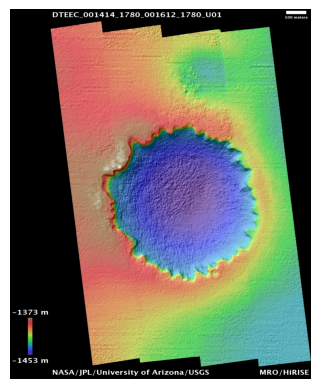

In [3]:
# 显示jpg
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open(jpg_path)
plt.imshow(img)
plt.axis('off')

In [4]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

dataset = gdal.Open(img_path, gdal.GA_ReadOnly)
# 读取数据
data = dataset.ReadAsArray()
# 获取数据信息
print('Driver: ', dataset.GetDriver().ShortName, '/', dataset.GetDriver().LongName)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, 'x', dataset.RasterCount)
print('Projection is ', dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
# ignore_value
ignore_value = dataset.GetRasterBand(1).GetNoDataValue()
print('ignore_value: ', ignore_value)

Driver:  PDS / NASA Planetary Data System
Size is  1279 x 1694 x 1
Projection is  PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",354.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -401.7064642816878 , -120698.1206180777 )
Pixel Size = ( 1.0118550737574 , -1.0118550737574 )
ignore_value:  -3.4028226550889045e+38


In [5]:
# 删除ignore_value
# data = data[data != ignore_value]
data.shape

(1694, 1279)

In [6]:
# 只取去除ignore_value后有效数据数量大于1000的行
data = data[:, np.sum(data != ignore_value, axis=0) > 1000]
data.shape

(1694, 1030)

In [7]:
import scipy.signal as signal
import numpy as np


# 计算相关长度
def calculate_correlation_length(A, dr):
    # 求1D、2D粗糙面相关长度
    # input:
    #     A:粗糙面的高度坐标
    #     dr：横向分辨率（如果是2D粗糙面，假设是x方向和y方向分辨率是一样的）
    # output:
    #     val:1D粗糙面返回1个值
    #         2D粗糙面返回一个1*2的向量
    #             第一个为A[:,0]方向
    #             第二个为A[0,:]方向
    er = 1e-1  # 误差
    m = A.shape
    if len(m) > 2 or len(m) == 0:
        print('input error')
        return []
    elif len(m) == 1:
        avg = np.mean(A)
        A = A - avg

        n = np.prod(A.shape)
        x = np.arange(0, n) * dr

        C = signal.correlate(A, A)
        h = max(C)
        dff = C[n - 1:] - h / np.exp(1)
        if np.sum(np.abs(dff) < er) == 1:
            return x[np.abs(dff) < er][0]
        else:
            index = np.where(dff < 0)[0][0]
            x1 = x[index]
            x2 = x[index - 1]
            y1 = abs(dff[index])
            y2 = dff[index - 1]
            return (y1 * x1 + y2 * x2) / (y1 + y2)
    else:
        avg = np.mean(A)
        A = A - avg

        C1 = np.zeros(m[0])
        for ii in range(m[0]):
            C1[ii] = np.sum(A[0:-ii or None, :] * A[ii:, :])

        x = np.arange(0, m[0]) * dr
        h = max(C1)
        dff = C1 - h / np.exp(1)
        if np.sum(np.abs(dff) < er) == 1:
            val = np.array([x[np.abs(dff) < er][0]])
        else:
            index = np.where(dff < 0)[0][0]
            x1 = x[index]
            x2 = x[index - 1]
            y1 = abs(dff[index])
            y2 = dff[index - 1]
            val = np.array([(y1 * x1 + y2 * x2) / (y1 + y2)])

        C1 = np.zeros(m[1])
        for ii in range(m[1]):
            C1[ii] = np.sum(A[:, 0:-ii or None] * A[:, ii:])

        x = np.arange(0, m[1]) * dr
        h = max(C1)
        dff = C1 - h / np.exp(1)
        if np.sum(np.abs(dff) < er) == 1:
            return np.append(val, x[np.abs(dff) < er][0])
        else:
            index = np.where(dff < 0)[0][0]
            x1 = x[index]
            x2 = x[index - 1]
            y1 = abs(dff[index])
            y2 = dff[index - 1]
            return np.append(val, (y1 * x1 + y2 * x2) / (y1 + y2))

In [8]:
map_scale = 1.01
actural_interval = 20  # m
interval = int(actural_interval / map_scale)

In [9]:
from scipy.signal import convolve
def filter(dem,interval):
    filter_dem = dem[dem!=ignore_value]
    filter_dem = np.pad(filter_dem, (interval, interval), 'edge')
    # 对间隔interval的数据进行拟合，得到大范围的data的趋势
    filter_kernel = np.ones(interval) / interval
    # 应用滤波器,边界填充方式为镜像填充
    filtered_data = convolve(filter_dem, filter_kernel, mode='same', method='auto')
    # 去除边界
    filtered_data = filtered_data[interval:-interval]
    filter_dem = filter_dem[interval:-interval]
    dem_data = filter_dem - filtered_data
    return dem_data 

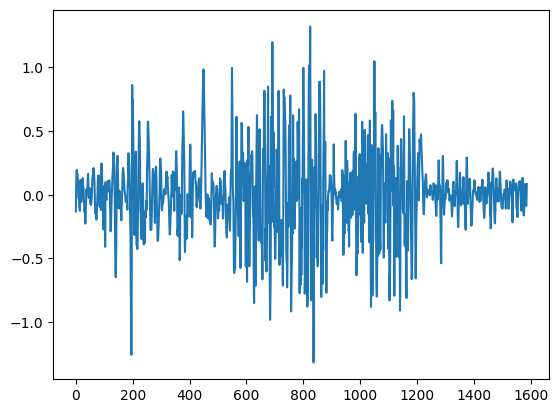

In [10]:
plt.plot(filter(data[:,-500], interval))

In [11]:
import tqdm
correlation_length = []
pbar = tqdm.tqdm(total=data.shape[1])
# 对每一行进行计算
for i in range(data.shape[1]):
    filtered_data = filter(data[:,i], interval)
    hanning_window = np.hanning(filtered_data.shape[0])
    filtered_data = filtered_data * hanning_window
    correlation_length.append(calculate_correlation_length(filtered_data, map_scale))
    pbar.update(1)
pbar.close()

100%|██████████| 1030/1030 [00:00<00:00, 1650.29it/s]


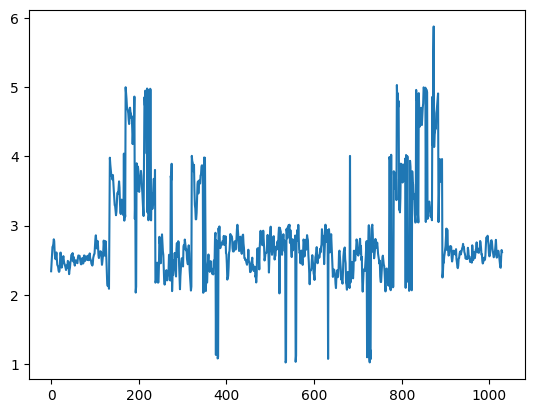

In [12]:
plt.plot(correlation_length)

(array([ 2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
         0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

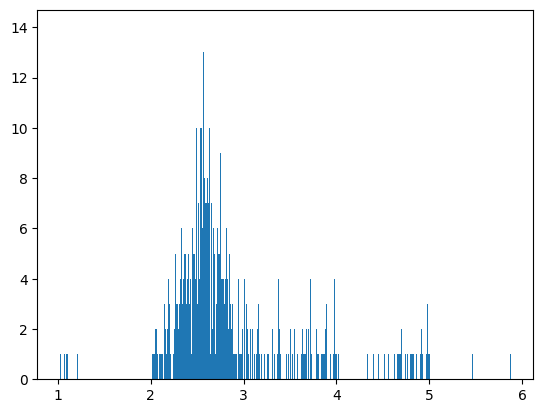

In [13]:
# 画直方图
plt.hist(correlation_length, bins=1000)

In [14]:
np.max(correlation_length)

5.8774575805048315

In [15]:
np.min(correlation_length)

1.0218989045076954

14

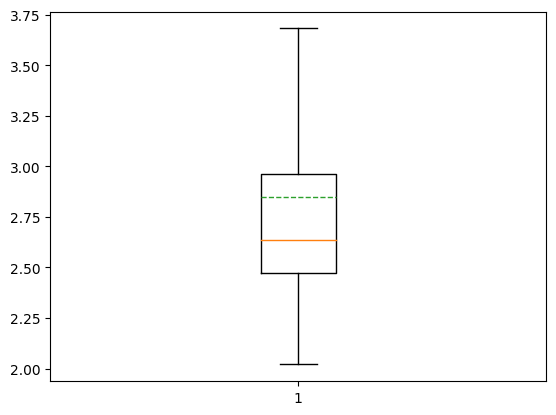

In [16]:
# 画箱线图，不显示异常值
plt.boxplot(correlation_length, showfliers=False,meanline=True,showmeans=True)
# 箱线图异常值的个数
temp = np.sum(np.array(correlation_length) < 2)
temp

In [17]:
# 去除异常值，比中位数大2倍标准差的值
correlation_length = np.array(correlation_length)
mid = np.median(correlation_length)
std = np.std(correlation_length)
mid

2.634481662585736

In [18]:
# 去除异常值
correlation_length = correlation_length[correlation_length < mid + 2 * std]
correlation_length = correlation_length[correlation_length > mid - 2 * std]

(array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
        0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1.,
        0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 2., 0., 1., 1.,
        2., 0., 1., 0., 0., 0., 0., 1., 0., 3., 1., 2., 0., 5., 2., 1., 3.,
        1., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 1., 0., 3., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 2., 0., 1., 1., 1.,
        2., 2., 1., 2., 3., 1., 1., 1., 2., 0., 2., 0., 1., 2., 0., 2., 0.,
        3., 2., 1., 2., 0., 0., 0., 1., 0., 2., 1., 0., 0., 1., 2., 1., 1.,
        2., 3., 2., 1., 1., 2., 1., 1., 2., 1., 5., 0., 0., 1., 2., 3., 2.,
        1., 4., 0., 2., 3., 1., 2., 2., 1., 3., 0., 2., 1., 1., 1., 1., 2.,
        2., 0., 2., 1., 1., 2., 2., 2., 1., 0., 3., 0., 3., 3., 1., 2., 2.,
        1., 2., 3., 0., 0., 2., 4., 4., 1., 2., 1., 4., 2., 4., 2., 1., 2.,
        4., 

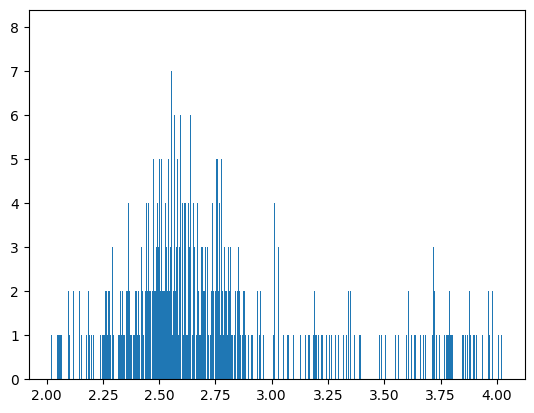

In [19]:
# 直方图
plt.hist(correlation_length, bins=1000)

{'whiskers': [<matplotlib.lines.Line2D at 0x24f3f08d400>,
 'caps': [<matplotlib.lines.Line2D at 0x24f3f08d9a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24f3f08d130>],
 'medians': [<matplotlib.lines.Line2D at 0x24f3f08df40>],
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x24f3f095250>]}

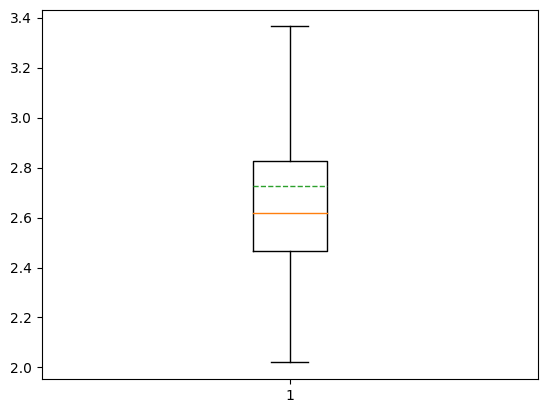

In [20]:
# 画箱线图，不显示异常值
plt.boxplot(correlation_length, showfliers=False,meanline=True,showmeans=True)